# 0. 라이브러리 세팅

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import warnings
warnings.filterwarnings('ignore')

In [3]:
# 맷플롯립 한글 설정 
# matplotlib Korean font
plt.rc('font', family='Malgun Gothic')

In [136]:
# 모든 컬럼을 표시하도록 설정
pd.set_option('display.max_columns', None)

# 컬럼의 너비 제한 해제
pd.set_option('display.max_colwidth', None)

# 출력할 행의 수를 설정 (필요에 따라 조정)
pd.set_option('display.max_rows', 700)


# 1. 데이터 로드

In [5]:
# 병합된 건축물대장 데이터 불러오기
building_merged = pd.read_csv('00data/13.세종시_건축물대장_통합.csv')
building_merged.head(2)

,plat_plc,sgg_cd,emd_cd,plat_gb_cd,bun,ji,regstr_gb_cd_nm,regstr_kind_nm,new_plat_plc,bld_nm,na_road_cd,na_bjdong_cd,na_ugrnd_cd_x,na_main_bun,na_sub_bun,dong_nm,plat_area,arch_area,bc_rat,tot_area,vl_rat_estm_tot_area,vl_rat,main_purps_cd_nm_x,etc_purps_x,hhld_cnt,fmly_cnt,heit,grnd_flr_cnt,ugrnd_flr_cnt,ride_use_elvt_cnt,emgen_use_elvt_cnt,atch_bld_area,tot_dong_tot_area,indr_mech_utcnt,indr_mech_area,oudr_mech_utcnt,oudr_mech_area,indr_auto_utcnt,indr_auto_area,oudr_auto_utcnt,oudr_auto_area,pms_day,stcns_day,use_apr_day,pmsno_year,pmsno_kik_cd_nm,pmsno_gb_cd_nm,ho_cnt,crtn_day_x,PNU,na_ugrnd_cd_y,flr_div_cd_nm,flr_num,flr_num_nm,main_purps_cd,main_purps_cd_nm_y,etc_purps_y,area_sqm,sub_atch_gb_cd,sub_atch_gb_cd_nm,area_excl_yn,crtn_day_y
0,세종특별자치시 반곡동 1035번지,36110,10100,0,1035,0,집합,표제부,세종특별자치시 시청대로 598,수루배마을 6단지,3.611023e+11,10101.0,0.0,598.0,NaN,618동,0.0,396.12,0.0,2843.03,2843.03,0.0,공동주택,공동주택(아파트),31,0,34.25,11,1,0,1,0.0,2843.03,0,0.0,0,0.0,0,0.0,0,0.0,20161117.0,20161208.0,20190607.0,2016.0,행정중심복합도시건설청,주택건설사업계획승인,0,20231211,3611010100110350000,0.0,지상,10,10층,2001.0,아파트,공동주택(아파트),271.77,0.0,주건축물,0.0,20231211
1,세종특별자치시 반곡동 1035번지,36110,10100,0,1035,0,집합,표제부,세종특별자치시 시청대로 598,수루배마을 6단지,3.611023e+11,10101.0,0.0,598.0,NaN,615동,0.0,439.92,0.0,4250.66,4250.66,0.0,공동주택,공동주택(아파트),46,0,47.54,16,1,0,1,0.0,4250.66,0,0.0,0,0.0,0,0.0,0,0.0,20161117.0,20161208.0,20190607.0,2016.0,행정중심복합도시건설청,주택건설사업계획승인,0,20231211,3611010100110350000,0.0,지상,15,15층,2001.0,아파트,공동주택(아파트),208.30,0.0,주건축물,0.0,20231211


In [81]:
# geojson파일 불러오기
sejong_zone = gpd.read_file('00data/11.세종시_대상구역도.geojson')
zone_sanga = gpd.read_file('00data/14.대상구역_상가개폐업정보.geojson')
bus_sejong = gpd.read_file('00data/15.대상구역_버스정류장.geojson')
total_bld = gpd.read_file('00data/지도_세종시_건물_주소_경계내.geojson')

# 2. 상가개폐업데이터 전처리

### 지도 기준으로 병합

In [82]:
# index right 드랍
zone_sanga.drop('index_right', axis=1, inplace=True)
# total_bld.drop('index_right', axis=1, inplace=True)

In [83]:
# 모든 점을 포함하여 공간 조인 수행 (left join)
sanga_land = gpd.sjoin(total_bld, zone_sanga, how='inner', predicate='contains', lsuffix='left', rsuffix='right')
print(sanga_land.shape)
# sanga_land.head(1)

(21378, 38)


In [84]:
# 통신판매업에 대해서 분석 
telem = sanga_land[sanga_land['service_nm']=='통신판매업'].drop(['geometry'], axis=1)
telem.plc_area.isnull().sum() / len(telem) * 100
# 통신 판매업 다 드랍 - 인터넷으로 자택으로 운영하는 경우가 많아 제외

100.0

In [85]:
# 건강기능식품업에 대해서 분석
# 통신판매업에 대해서 분석 
health = sanga_land[sanga_land['service_nm']=='건강기능식품일반판매업'].drop(['geometry'], axis=1)
health.plc_area.isnull().sum() / len(health) * 100
# 통신 판매업 다 드랍 - 인터넷으로 자택으로 운영하는 경우가 많아 제외

56.82574916759157

In [86]:
# 통신 판매업 및 집단 급식소 제외 
print(sanga_land.shape)
sanga_land = sanga_land[sanga_land['service_nm']!='통신판매업']
sanga_land = sanga_land[sanga_land['service_nm']!='집단급식소']
sanga_land = sanga_land[~((sanga_land['service_nm']=='건강기능식품일반판매업')&
                         (sanga_land['plc_area'].isnull()==True))]
print(sanga_land.shape)

(21378, 38)
(13769, 38)


### 상가 테스트*******

In [ ]:
kill_sanga = [''] 
# 불순분자가 많은 애들은 함수를 적용한다



In [159]:
sanga_temp = sanga_land[sanga_land['rd_addr_left']=='세종특별자치시 남세종로 357'].drop(['geometry'], axis=1)
sanga_temp = sanga_temp.iloc[:, 11:-149]
sanga_temp.sort_values('lcpmt_dt', ascending=True)

# 만약에 상가라면, 주소명에서 상가들어간 것만 추출
# 반대로 상가인데, 주소명에 상가가 없는 경우를 제외하자
print(sanga_temp.shape)
# sanga_temp = sanga_temp[~((sanga_temp.bld_nm.str.contains('단지'))&(~sanga_temp.rd_addr_right.str.contains('상가')))]
sanga_temp

(27, 21)


,rd_addr_left,bld_nm,index_right,service_nm,lcpmt_dt,rtrcn_dt,biz_stts_cd,biz_stts_nm,dtls_stts_cd,dtls_stts_nm,cls_date,tc_strt_dt,tc_end_dt,re_op_dt,plc_area,zip_cd,addr,rd_addr_right,rd_zip_cd,bplc_nm,biz_type
189,세종특별자치시 남세종로 357,새샘마을1단지,4380,식품자동판매기업,2023-09-22,None,1,영업/정상,None,영업,None,None,None,None,1.00,339-010,세종특별자치시 소담동 597 새샘마을1단지,세종특별자치시 남세종로 357 상가2동 1층 208호 (소담동 새샘마을1단지),None,24시 무인카페 만월경 세종소담점,식품자동판매기영업
189,세종특별자치시 남세종로 357,새샘마을1단지,4255,식품자동판매기업,2018-11-26,None,3,폐업,None,폐업,2020-02-10,None,None,None,3.00,339-010,세종특별자치시 소담동 32-53 새샘마을1단지,세종특별자치시 남세종로 357 상가1동 1층 103호 (소담동 새샘마을1단지),None,이마트24 세종소담점,식품자동판매기영업
189,세종특별자치시 남세종로 357,새샘마을1단지,4347,식품자동판매기업,2022-04-21,None,3,폐업,None,폐업,2022-10-26,None,None,None,3.30,339-010,세종특별자치시 소담동 597 새샘마을1단지,세종특별자치시 남세종로 357 상가1동 1층 105호 (소담동 새샘마을1단지),None,GS25세종새샘점,식품자동판매기영업
189,세종특별자치시 남세종로 357,새샘마을1단지,14011,축산판매업,2019-06-20,None,3,폐업,None,폐업,2019-11-05,None,None,None,24.06,None,세종특별자치시 소담동 32-53 새샘마을1단지 상가3동 301호,세종특별자치시 남세종로 357 상가3동 1층 301호 (소담동 새샘마을1단지),30150,소담미트,식육판매업
189,세종특별자치시 남세종로 357,새샘마을1단지,3089,미용업,2018-12-18,None,1,영업/정상,None,영업,None,None,None,None,35.23,339-010,세종특별자치시 소담동 32-53번지 새샘마을1단지,세종특별자치시 남세종로 357 206호 (소담동 새샘마을1단지),None,소담 헤어,일반미용업
189,세종특별자치시 남세종로 357,새샘마을1단지,1995,담배소매업,2022-01-11,None,3,폐업,None,폐업처리,2023-09-05,None,None,None,25.33,None,세종특별자치시 소담동 597 새샘마을1단지,세종특별자치시 남세종로 357 1층 301호~306호 (소담동 새샘마을1단지),30150,홈마트,None
189,세종특별자치시 남세종로 357,새샘마을1단지,10117,일반음식점,2022-10-31,None,3,폐업,None,폐업,2023-09-18,None,None,None,25.33,339-010,세종특별자치시 소담동 597 새샘마을1단지 3동 308호,세종특별자치시 남세종로 357 상가3동 3층 308호 (소담동 새샘마을1단지),None,로만플라워카페,기타
189,세종특별자치시 남세종로 357,새샘마을1단지,2006,담배소매업,2022-03-07,None,3,폐업,None,폐업처리,2023-11-03,None,None,None,25.33,None,세종특별자치시 소담동 597 새샘마을1단지,세종특별자치시 남세종로 357 상가동 105호 (소담동 새샘마을1단지),30150,새샘편의점,None
189,세종특별자치시 남세종로 357,새샘마을1단지,1788,담배소매업,2019-06-04,None,3,폐업,None,폐업처리,2019-11-20,None,None,None,25.33,None,세종특별자치시 소담동 32번지 53호 새샘마을1단지,세종특별자치시 남세종로 357 상가3동 301~306호 (소담동 새샘마을1단지),30150,롯데슈퍼 세종소담점,None
189,세종특별자치시 남세종로 357,새샘마을1단지,1744,담배소매업,2018-11-22,None,3,폐업,None,폐업처리,2020-02-10,None,None,None,25.33,None,세종특별자치시 소담동 32번지 53호 새샘마을1단지,세종특별자치시 남세종로 357 상가1동 103호 (소담동 새샘마을1단지),30150,소담마트,None


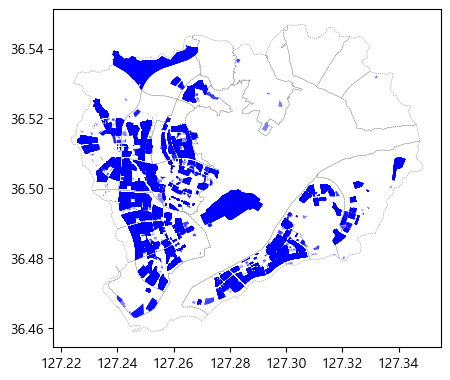

In [10]:
fig, ax = plt.subplots(figsize=(5, 5))
sejong_zone.plot(ax=ax, facecolor='none', edgecolor='gray', linewidth=0.3, linestyle='--')
sanga_land.plot(ax=ax, color='blue', alpha = 0.5)
# unassigned_points.plot(ax=ax, color='red', markersize=1)
plt.show()

In [94]:
# 상태가 폐업이지만 cls_date 가 없는 경우 -> drop
print(sanga_land.shape)
sanga_land = sanga_land[~((sanga_land.cls_date.isnull()) & (sanga_land.biz_stts_nm == '폐업'))]
print(sanga_land.shape)
sanga_land.head(1).drop(['geometry'], axis=1)

(13769, 38)
(13753, 38)


,ADR_MNG_NO,SIG_CD,RN_CD,BULD_SE_CD,BULD_MNNM,BULD_SLNO,BUL_MAN_NO,EQB_MAN_SN,EFFECT_DE,emd_cd,emd_nm,rd_addr_left,bld_nm,index_right,service_nm,lcpmt_dt,rtrcn_dt,biz_stts_cd,biz_stts_nm,dtls_stts_cd,dtls_stts_nm,cls_date,tc_strt_dt,tc_end_dt,re_op_dt,plc_area,zip_cd,addr,rd_addr_right,rd_zip_cd,bplc_nm,biz_type,lon,lat,EMD_CD,COL_ADM_SE,EMD_NM
4,36110110325807700000900000,36110,3258077,0,9,0,0,26508,20220223,3611011000,어진동,세종특별자치시 다솜1로 9,한뜰마을4단지,10487,일반음식점,2023-07-27,None,1,영업/정상,None,영업,None,None,None,None,114.13,339-012,세종특별자치시 어진동 520,세종특별자치시 다솜1로 21 한뜰마을4단지 상가 301동 1층 156 157호 (어진동),None,뉴욕버거 세종어진점,경양식,127.255563,36.500112,36110110,36110,어진동


## 2. 개별 그룹별 적용 함수

In [95]:
# 1. 필지 내 프랜차이즈 비율 파악(전체 일괄 적용)
# bplc_nm 중에 프랜차이즈의 이름이 포함이 되어있으면 frnch = 1, 아니면 frnch = 0

franchise = ['스타벅스', '이디야', '투썸플레이스', '커피빈', '할리스', '탐앤탐스', 
             '빽다방', '엔제리너스', '파스쿠찌', '커피베이', '60계', 
             '홍콩반점', '올리브영', '가마로강정', '가마치통닭', '강다짐',
             '걸작떡볶이치킨', '고릴라캠핑', '공차', '교촌치킨', '굽네치킨', 
             '김가네', '노랑통닭', '노브랜드 버거', '다이소', '도미노', 
             '롯데리아', '맘스터치','메가엠지씨', '멕시카나', '버거킹']

sanga_land['frnch'] = sanga_land['bplc_nm'].apply(lambda x: 1 if any(f in x for f in franchise) else 0)
frnch_sanga = sanga_land[sanga_land.frnch == 1]
print('프랜차이즈 수/전체 상가 수: \n      ', frnch_sanga.shape[0], '/',sanga_land.shape[0])
frnch_sanga.head(3).drop(['geometry'], axis=1)

프랜차이즈 수/전체 상가 수: 
       215 / 13753


,ADR_MNG_NO,SIG_CD,RN_CD,BULD_SE_CD,BULD_MNNM,BULD_SLNO,BUL_MAN_NO,EQB_MAN_SN,EFFECT_DE,emd_cd,emd_nm,rd_addr_left,bld_nm,index_right,service_nm,lcpmt_dt,rtrcn_dt,biz_stts_cd,biz_stts_nm,dtls_stts_cd,dtls_stts_nm,cls_date,tc_strt_dt,tc_end_dt,re_op_dt,plc_area,zip_cd,addr,rd_addr_right,rd_zip_cd,bplc_nm,biz_type,lon,lat,EMD_CD,COL_ADM_SE,EMD_NM,frnch
4,36110110325807700000900000,36110,3258077,0,9,0,0,26508,20220223,3611011000,어진동,세종특별자치시 다솜1로 9,한뜰마을4단지,22934,휴게음식점,2022-07-14,None,1,영업/정상,None,영업,None,None,None,None,51.86,339-012,세종특별자치시 어진동 520,세종특별자치시 다솜1로 21 1층 111 112호 (어진동),None,빽다방 세종한뜰마을4단지점,커피숍,127.255563,36.500112,36110110,36110,어진동,1
7,36110116335282800003200000,36110,3352828,0,32,0,0,24847,20200825,3611011600,해밀동,세종특별자치시 해밀3로 32,해밀마을1단지,10168,일반음식점,2022-11-29,None,1,영업/정상,None,영업,None,None,None,None,42.12,None,세종특별자치시 해밀동 산 8 해밀마을1단지 105호,세종특별자치시 해밀3로 32 근린생활시설동 지1층 105호 (해밀동 해밀마을1단지),None,60계치킨 세종해밀점,호프/통닭,127.265646,36.526838,36110116,36110,해밀동,1
7,36110116335282800003200000,36110,3352828,0,32,0,0,24847,20200825,3611011600,해밀동,세종특별자치시 해밀3로 32,해밀마을1단지,22663,휴게음식점,2021-03-12,None,1,영업/정상,None,영업,None,None,None,None,44.30,None,세종특별자치시 해밀동 산 8 해밀마을1단지,세종특별자치시 해밀3로 32 지하1층 122호 (해밀동 해밀마을1단지),None,메가엠지씨커피 세종해밀점,커피숍,127.265646,36.526838,36110116,36110,해밀동,1


In [96]:
# 2. 면적 전처리
# Null 값에 중위값을 적용: 이상치에 민감하지 않음
sanga_land['plc_area'] = sanga_land.groupby('rd_addr_left')['plc_area'].transform(lambda x: x.fillna(x.median())) # 필지 내 상가 면적 중위값으로 대체
# sanga_land.drop('geometry', axis=1).iloc[12080:120, :]
# 호실, 개업날짜 별로 데이터 정렬
# sanga_land = sanga_land.sort_values(by=['rd_addr', 'plc_area', 'lcpmt_dt'], ascending=[True, True, True])
sanga_land.head(3).drop(['geometry'], axis=1)

,ADR_MNG_NO,SIG_CD,RN_CD,BULD_SE_CD,BULD_MNNM,BULD_SLNO,BUL_MAN_NO,EQB_MAN_SN,EFFECT_DE,emd_cd,emd_nm,rd_addr_left,bld_nm,index_right,service_nm,lcpmt_dt,rtrcn_dt,biz_stts_cd,biz_stts_nm,dtls_stts_cd,dtls_stts_nm,cls_date,tc_strt_dt,tc_end_dt,re_op_dt,plc_area,zip_cd,addr,rd_addr_right,rd_zip_cd,bplc_nm,biz_type,lon,lat,EMD_CD,COL_ADM_SE,EMD_NM,frnch
4,36110110325807700000900000,36110,3258077,0,9,0,0,26508,20220223,3611011000,어진동,세종특별자치시 다솜1로 9,한뜰마을4단지,10487,일반음식점,2023-07-27,None,1,영업/정상,None,영업,None,None,None,None,114.13,339-012,세종특별자치시 어진동 520,세종특별자치시 다솜1로 21 한뜰마을4단지 상가 301동 1층 156 157호 (어진동),None,뉴욕버거 세종어진점,경양식,127.255563,36.500112,36110110,36110,어진동,0
4,36110110325807700000900000,36110,3258077,0,9,0,0,26508,20220223,3611011000,어진동,세종특별자치시 다솜1로 9,한뜰마을4단지,9917,일반음식점,2022-05-20,None,3,폐업,None,폐업,2023-06-20,None,None,None,29.08,339-012,세종특별자치시 어진동 520,세종특별자치시 다솜1로 21 한뜰마을4단지 상가1동 1층 116호 (어진동),None,감동식혜 행복점,기타,127.255563,36.500112,36110110,36110,어진동,0
4,36110110325807700000900000,36110,3258077,0,9,0,0,26508,20220223,3611011000,어진동,세종특별자치시 다솜1로 9,한뜰마을4단지,10211,일반음식점,2023-01-03,None,1,영업/정상,None,영업,None,None,None,None,51.76,339-012,세종특별자치시 어진동 520,세종특별자치시 다솜1로 21 한뜰마을 4단지 근린생활시설 301동 1층 129호 (어진동),None,행복수제돈가스,경양식,127.255563,36.500112,36110110,36110,어진동,0


In [97]:
# Date-time 형식과 컬럼 2012.07~2024.05 생성 (일괄)
sanga_land['lcpmt_dt'] = pd.to_datetime(sanga_land['lcpmt_dt'])

# 2012.07~2024.05 컬럼 만들기 (일괄)
month_list = pd.date_range(start='2012-07-01', end='2024-05-01', freq='MS').strftime('%Y-%m').tolist()
for i in month_list:
    sanga_land[i] = 0
sanga_land.drop(['geometry'], axis=1).head(1)

,ADR_MNG_NO,SIG_CD,RN_CD,BULD_SE_CD,BULD_MNNM,BULD_SLNO,BUL_MAN_NO,EQB_MAN_SN,EFFECT_DE,emd_cd,emd_nm,rd_addr_left,bld_nm,index_right,service_nm,lcpmt_dt,rtrcn_dt,biz_stts_cd,biz_stts_nm,dtls_stts_cd,dtls_stts_nm,cls_date,tc_strt_dt,tc_end_dt,re_op_dt,plc_area,zip_cd,addr,rd_addr_right,rd_zip_cd,bplc_nm,biz_type,lon,lat,EMD_CD,COL_ADM_SE,EMD_NM,frnch,2012-07,2012-08,2012-09,2012-10,2012-11,2012-12,2013-01,2013-02,2013-03,2013-04,2013-05,2013-06,2013-07,2013-08,2013-09,2013-10,2013-11,2013-12,2014-01,2014-02,2014-03,2014-04,2014-05,2014-06,2014-07,2014-08,2014-09,2014-10,2014-11,2014-12,2015-01,2015-02,2015-03,2015-04,2015-05,2015-06,2015-07,2015-08,2015-09,2015-10,2015-11,2015-12,2016-01,2016-02,2016-03,2016-04,2016-05,2016-06,2016-07,2016-08,2016-09,2016-10,2016-11,2016-12,2017-01,2017-02,2017-03,2017-04,2017-05,2017-06,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,2018-05,2018-06,2018-07,2018-08,2018-09,2018-10,2018-11,2018-12,2019-01,2019-02,2019-03,2019-04,2019-05,2019-06,2019-07,2019-08,2019-09,2019-10,2019-11,2019-12,2020-01,2020-02,2020-03,2020-04,2020-05,2020-06,2020-07,2020-08,2020-09,2020-10,2020-11,2020-12,2021-01,2021-02,2021-03,2021-04,2021-05,2021-06,2021-07,2021-08,2021-09,2021-10,2021-11,2021-12,2022-01,2022-02,2022-03,2022-04,2022-05,2022-06,2022-07,2022-08,2022-09,2022-10,2022-11,2022-12,2023-01,2023-02,2023-03,2023-04,2023-05,2023-06,2023-07,2023-08,2023-09,2023-10,2023-11,2023-12,2024-01,2024-02,2024-03,2024-04,2024-05
4,36110110325807700000900000,36110,3258077,0,9,0,0,26508,20220223,3611011000,어진동,세종특별자치시 다솜1로 9,한뜰마을4단지,10487,일반음식점,2023-07-27,None,1,영업/정상,None,영업,None,None,None,None,114.13,339-012,세종특별자치시 어진동 520,세종특별자치시 다솜1로 21 한뜰마을4단지 상가 301동 1층 156 157호 (어진동),None,뉴욕버거 세종어진점,경양식,127.255563,36.500112,36110110,36110,어진동,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [98]:
# 3. 공실 수, 면적 계산, 프랜차이즈 수 및 비율 계산

# 3.1. 공실 수 계산

# 프렌차이즈 여부 연산
def set_franchise(row):
    if row['frnch'] == 1: # 해당 상가가 프렌차이즈일 경우, 해당 가게의 영업 여부가 곧 해당 월의 프렌차이즈 수
        if row['biz_stts_cd'] == 1: # 현재 상태가 영업인 경우
            open_months = pd.date_range(start=row['lcpmt_dt']- pd.DateOffset(days=30), end='2024-05-01', freq='MS').strftime('%Y-%m').tolist()
            for month in open_months:
                row[month] = 1
        if row['biz_stts_cd'] == 3: # 현재 상태가 폐업인 경우
            open_months = pd.date_range(start=row['lcpmt_dt']-pd.DateOffset(days=30), end=row['cls_date'], freq='MS').strftime('%Y-%m').tolist()
            for month in open_months:
                row[month] = 1
    return row

# 공실 여부 연산
def set_monthly_values(row): # 해당 줄 기준 연산
    if row['biz_stts_cd'] == 1: # 현재 상태가 영업인 경우
        open_months = pd.date_range(start=row['lcpmt_dt']- pd.DateOffset(days=30), end='2024-05-01', freq='MS').strftime('%Y-%m').tolist()
        for month in open_months:
            row[month] = 1
    if row['biz_stts_cd'] == 3: # 현재 상태가 폐업인 경우
        open_months = pd.date_range(start=row['lcpmt_dt']-pd.DateOffset(days=30), end=row['cls_date'], freq='MS').strftime('%Y-%m').tolist()
        for month in open_months:
            row[month] = 1
    return row

# 공실 면적 연산
def set_monthly_area(row):
    if row['biz_stts_cd'] == 1: # 현재 상태가 영업인 경우
        open_months = pd.date_range(start=row['lcpmt_dt']- pd.DateOffset(days=30), end='2024-05-01', freq='MS').strftime('%Y-%m').tolist()
        for month in open_months:
            row[month] = row['plc_area']
    if row['biz_stts_cd'] == 3: # 현재 상태가 폐업인 경우
        open_months = pd.date_range(start=row['lcpmt_dt']-pd.DateOffset(days=30), end=row['cls_date'], freq='MS').strftime('%Y-%m').tolist()
        for month in open_months:
            row[month] = row['plc_area']
    return row

In [99]:
#함수화

def pnu_to_frame(df):

    # 1. 프랜차이즈 수 연산
    temp_df = df.apply(lambda row: set_franchise(row), axis=1)

    # 호실 수 합계 데이터프레임
    total_frnchs = temp_df[month_list].sum(axis=0).to_frame()
    total_frnchs.columns = ["Tot_frnchs"]                    


    # 2. 공실 여부 함수 적용
    temp_df = df.apply(lambda row: set_monthly_values(row), axis=1)

    # 호실 수 합계 데이터프레임
    total_rooms = temp_df[month_list].sum(axis=0).to_frame()
    total_rooms.columns = ["Tot_Rooms"]

    # 3. 공실 면적 함수 적용
    temp_df = df.apply(lambda row: set_monthly_area(row), axis=1)

    # 면적 합계 데이터프레임
    total_area = temp_df[month_list].sum(axis=0).to_frame()
    total_area.columns = ["Tot_Area"]

    # *.최종 그룹별 데이터프레임 생성
    total_set = pd.concat([total_rooms, total_frnchs, total_area], axis=1)
    
    # 프랜차이즈 비율 계산
    total_set['frnch_ratio'] = total_set['Tot_frnchs'] / total_set['Tot_Rooms']

    # PNU, geometry 추가
    geometry = df.iloc[0].geometry
    total_set['geometry'] = geometry
    total_set['rd_addr'] = df.iloc[0].rd_addr_left

    # gpd.GeoDataFrame 생성
    total_set = gpd.GeoDataFrame(total_set, geometry='geometry')

    return total_set

In [100]:
# 필지 단위로 적용시키는 방법
# 1. 필지 or 건물 단위로 병합된 개폐업데이터를 필지 단위로 추출해서 위의 일련의 함수들을 적용
# 2. 각각 나온 애들을 concat 시키기
master_land = sanga_land.groupby('rd_addr_left').apply(pnu_to_frame)
print(master_land.shape)
master_land.head()

(89089, 6)


Tot_Rooms  Tot_frnchs  Tot_Area  frnch_ratio  \
rd_addr_left                                                            
세종특별자치시 가름로 143 2012-07          1           0     81.81          0.0   
                2012-08          1           0     81.81          0.0   
                2012-09          1           0     81.81          0.0   
                2012-10          1           0     81.81          0.0   
                2012-11          1           0     81.81          0.0   

                                                                                                                                                                                                                                                                                                                   geometry  \
rd_addr_left                                                                                                                                                                                                                                                                                                                  
세종특별자치시 가름로 143 2012-07  POLYGON ((127.25643 36.49889, 127.25621 36.49891, 127.25600 36.49893, 127.25593 36.49899, 127.25599 36.49925, 127.25605 36.49942, 127.25623 36.49981, 127.25632 36.49986, 127.25675 36.49987, 127.25668 36.49963, 127.25664 36.49927, 127.25664 36.49900, 127.25664 36.49887, 127.25643 36.49889))   
                2012-08  POLYGON ((127.25643 36.49889, 127.25621 36.49891, 127.25600 36.49893, 127.25593 36.49899, 127.25599 36.49925, 127.25605 36.49942, 127.25623 36.49981, 127.25632 36.49986, 127.25675 36.49987, 127.25668 36.49963, 127.25664 36.49927, 127.25664 36.49900, 127.25664 36.49887, 127.25643 36.49889))   
                2012-09  POLYGON ((127.25643 36.49889, 127.25621 36.49891, 127.25600 36.49893, 127.25593 36.49899, 127.25599 36.49925, 127.25605 36.49942, 127.25623 36.49981, 127.25632 36.49986, 127.25675 36.49987, 127.25668 36.49963, 127.25664 36.49927, 127.25664 36.49900, 127.25664 36.49887, 127.25643 36.49889))   
                2012-10  POLYGON ((127.25643 36.49889, 127.25621 36.49891, 127.25600 36.49893, 127.25593 36.49899, 127.25599 36.49925, 127.25605 36.49942, 127.25623 36.49981, 127.25632 36.49986, 127.25675 36.49987, 127.25668 36.49963, 127.25664 36.49927, 127.25664 36.49900, 127.25664 36.49887, 127.25643 36.49889))   
                2012-11  POLYGON ((127.25643 36.49889, 127.25621 36.49891, 127.25600 36.49893, 127.25593 36.49899, 127.25599 36.49925, 127.25605 36.49942, 127.25623 36.49981, 127.25632 36.49986, 127.25675 36.49987, 127.25668 36.49963, 127.25664 36.49927, 127.25664 36.49900, 127.25664 36.49887, 127.25643 36.49889))   

                                 rd_addr  
rd_addr_left                              
세종특별자치시 가름로 143 2012-07  세종특별자치시 가름로 143  
                2012-08  세종특별자치시 가름로 143  
                2012-09  세종특별자치시 가름로 143  
                2012-10  세종특별자치시 가름로 143  
                2012-11  세종특별자치시 가름로 143

In [53]:
master_land[master_land['rd_addr'] == '세종특별자치시 고운뜰7길 9'].drop(['geometry'], axis=1)

Tot_Rooms  Tot_frnchs  Tot_Area  frnch_ratio  \
rd_addr_left                                                            
세종특별자치시 고운뜰7길 9 2012-07          0           0       0.0          NaN   
                2012-08          0           0       0.0          NaN   
                2012-09          0           0       0.0          NaN   
                2012-10          0           0       0.0          NaN   
                2012-11          0           0       0.0          NaN   
                2012-12          0           0       0.0          NaN   
                2013-01          0           0       0.0          NaN   
                2013-02          0           0       0.0          NaN   
                2013-03          0           0       0.0          NaN   
                2013-04          0           0       0.0          NaN   
                2013-05          0           0       0.0          NaN   
                2013-06          0           0       0.0          NaN   
                2013-07          0           0       0.0          NaN   
                2013-08          0           0       0.0          NaN   
                2013-09          0           0       0.0          NaN   
                2013-10          0           0       0.0          NaN   
                2013-11          0           0       0.0          NaN   
                2013-12          0           0       0.0          NaN   
                2014-01          0           0       0.0          NaN   
                2014-02          0           0       0.0          NaN   
                2014-03          0           0       0.0          NaN   
                2014-04          0           0       0.0          NaN   
                2014-05          0           0       0.0          NaN   
                2014-06          0           0       0.0          NaN   
                2014-07          0           0       0.0          NaN   
                2014-08          0           0       0.0          NaN   
                2014-09          0           0       0.0          NaN   
                2014-10          0           0       0.0          NaN   
                2014-11          0           0       0.0          NaN   
                2014-12          0           0       0.0          NaN   
                2015-01          0           0       0.0          NaN   
                2015-02          0           0       0.0          NaN   
                2015-03          0           0       0.0          NaN   
                2015-04          0           0       0.0          NaN   
                2015-05          0           0       0.0          NaN   
                2015-06          0           0       0.0          NaN   
                2015-07          0           0       0.0          NaN   
                2015-08          0           0       0.0          NaN   
                2015-09          0           0       0.0          NaN   
                2015-10          0           0       0.0          NaN   
                2015-11          0           0       0.0          NaN   
                2015-12          0           0       0.0          NaN   
                2016-01          0           0       0.0          NaN   
                2016-02          0           0       0.0          NaN   
                2016-03          0           0       0.0          NaN   
                2016-04          0           0       0.0          NaN   
                2016-05          0           0       0.0          NaN   
                2016-06          0           0       0.0          NaN   
                2016-07          0           0       0.0          NaN   
                2016-08          0           0       0.0          NaN   
                2016-09          0           0       0.0          NaN   
                2016-10          0           0       0.0          NaN   
                2016-11          0           0       0.0          NaN   
          

## 2.3. 파일로 추출

In [101]:
# master_land.to_file('00data/22.지도병합_상가_정보.geojson', driver='GeoJSON')

In [ ]:
# 파일 다시 불러오기
master_land = gpd.read_file('00data/22.지도병합_상가_정보.geojson')

# 3. 시각화 

In [167]:
# tot_room 으로만 추출 
master_rooms = master_land[master_land.Type == 'Tot_Rooms']

<Axes: >

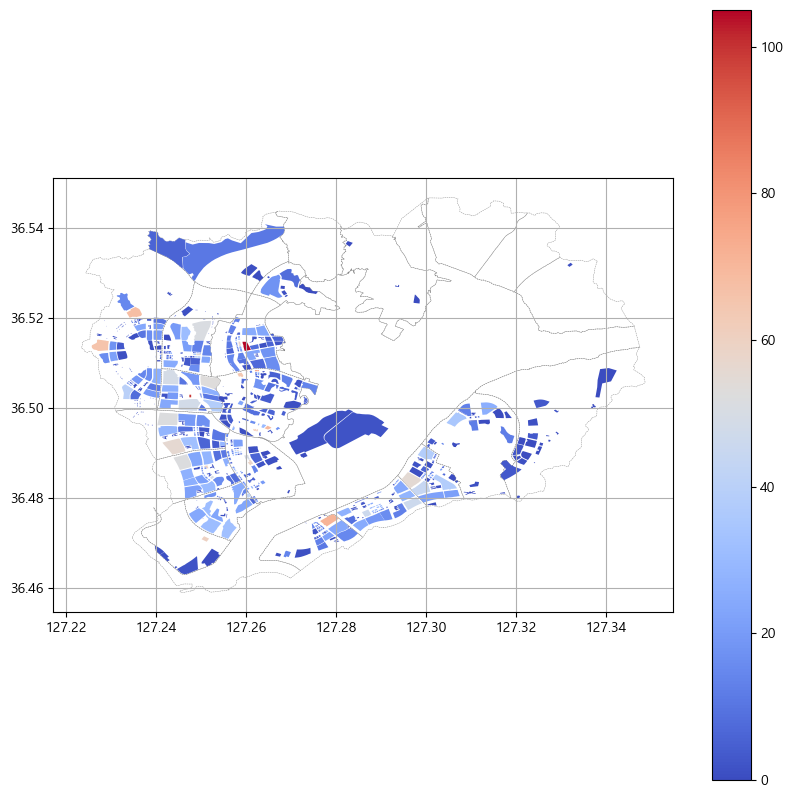

In [168]:
# 2012-07월 Tot-Rooms들만 시각화
fig, ax = plt.subplots(figsize=(10, 10))
ax.grid(True)
sejong_zone.plot(ax=ax, facecolor='none', edgecolor='gray', linewidth=0.3, linestyle='--')
master_rooms.plot(ax=ax, column='2020-12', cmap='coolwarm', legend=True)

In [169]:
# # 미친 애니메이션 시도
# from matplotlib.animation import FuncAnimation

# # 시각화를 위한 날짜 리스트 생성
# date_range = pd.date_range(start='2012-07-01', end='2024-05-01', freq='MS').strftime('%Y-%m').tolist()

# fig, ax = plt.subplots(figsize=(10, 10))

# def update(frame):
#     ax.clear()
#     ax.grid(True)
#     sejong_zone.plot(ax=ax, facecolor='none', edgecolor='gray', linewidth=0.3, linestyle='--')
#     master_rooms.plot(ax=ax, column=frame, cmap='coolwarm', legend=False)  # legend=False로 설정
#     ax.set_title(f'Rooms in {frame}')

# ani = FuncAnimation(fig, update, frames=date_range, repeat=True)

# # 애니메이션 저장 (GIF 형식)
# ani.save('rooms_animation.gif', writer='Pillow', fps=2)

# plt.show()

---